## Churn Analysis

The notebook contains a comprehensive churn analysis for an e-commerce website. The analysis focuses on identifying patterns and reasons behind customer churn, applying machine learning models, and providing actionable insights to reduce churn. Key areas include EDA, feature engineering, model building, and evaluation metrics.

## Importing necessary libraries

In [1]:
# Data Handling
import pandas as pd
import numpy as np

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# Data Imputing
from sklearn.impute import KNNImputer

# Modelling
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

import warnings
warnings.filterwarnings("ignore")

In [2]:
ecom = pd.read_excel("/kaggle/input/ecommerce-customer-churn-analysis-and-prediction/E Commerce Dataset.xlsx", sheet_name=1)

In [3]:
ecom.shape

(5630, 20)

In [4]:
df = ecom.copy()
ecom.head()

,CustomerID,Churn,Tenure,PreferredLoginDevice,CityTier,WarehouseToHome,PreferredPaymentMode,Gender,HourSpendOnApp,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,CouponUsed,OrderCount,DaySinceLastOrder,CashbackAmount
0,50001,1,4.0,Mobile Phone,3,6.0,Debit Card,Female,3.0,3,Laptop & Accessory,2,Single,9,1,11.0,1.0,1.0,5.0,159.93
1,50002,1,NaN,Phone,1,8.0,UPI,Male,3.0,4,Mobile,3,Single,7,1,15.0,0.0,1.0,0.0,120.90
2,50003,1,NaN,Phone,1,30.0,Debit Card,Male,2.0,4,Mobile,3,Single,6,1,14.0,0.0,1.0,3.0,120.28
3,50004,1,0.0,Phone,3,15.0,Debit Card,Male,2.0,4,Laptop & Accessory,5,Single,8,0,23.0,0.0,1.0,3.0,134.07
4,50005,1,0.0,Phone,1,12.0,CC,Male,NaN,3,Mobile,5,Single,3,0,11.0,1.0,1.0,3.0,129.60


In [5]:
ecom.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5630 entries, 0 to 5629
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   CustomerID                   5630 non-null   int64  
 1   Churn                        5630 non-null   int64  
 2   Tenure                       5366 non-null   float64
 3   PreferredLoginDevice         5630 non-null   object 
 4   CityTier                     5630 non-null   int64  
 5   WarehouseToHome              5379 non-null   float64
 6   PreferredPaymentMode         5630 non-null   object 
 7   Gender                       5630 non-null   object 
 8   HourSpendOnApp               5375 non-null   float64
 9   NumberOfDeviceRegistered     5630 non-null   int64  
 10  PreferedOrderCat             5630 non-null   object 
 11  SatisfactionScore            5630 non-null   int64  
 12  MaritalStatus                5630 non-null   object 
 13  NumberOfAddress   

In [6]:
# Percentage of Missing Values
round(ecom.isnull().sum()/ecom.shape[0] * 100, 2)

CustomerID                     0.00
Churn                          0.00
Tenure                         4.69
PreferredLoginDevice           0.00
CityTier                       0.00
WarehouseToHome                4.46
PreferredPaymentMode           0.00
Gender                         0.00
HourSpendOnApp                 4.53
NumberOfDeviceRegistered       0.00
PreferedOrderCat               0.00
SatisfactionScore              0.00
MaritalStatus                  0.00
NumberOfAddress                0.00
Complain                       0.00
OrderAmountHikeFromlastYear    4.71
CouponUsed                     4.55
OrderCount                     4.58
DaySinceLastOrder              5.45
CashbackAmount                 0.00
dtype: float64

## Data Cleaning

#### Categorical : Removing Duplicates

In [7]:
cat_cols = ecom.dtypes[ecom.dtypes == 'object'].index

for i in cat_cols:
    print(f"{i} ---> {ecom[i].unique()}")
    print()

PreferredLoginDevice ---> ['Mobile Phone' 'Phone' 'Computer']

PreferredPaymentMode ---> ['Debit Card' 'UPI' 'CC' 'Cash on Delivery' 'E wallet' 'COD' 'Credit Card']

Gender ---> ['Female' 'Male']

PreferedOrderCat ---> ['Laptop & Accessory' 'Mobile' 'Mobile Phone' 'Others' 'Fashion' 'Grocery']

MaritalStatus ---> ['Single' 'Divorced' 'Married']



In [8]:
# Change values to lower and replace space with _ for cleaning
for i in cat_cols:
    ecom[i] = ecom[i].apply(lambda x: x.lower().replace(" ", "_"))

In [9]:
# Replacing duplicate values
ecom["PreferredLoginDevice"].replace("phone", "mobile_phone", inplace = True)
ecom["PreferredPaymentMode"].replace(["cc", "cod"], ["credit_card", "cash_on_delivery"], inplace = True)
ecom["PreferedOrderCat"].replace("mobile_phone", "mobile", inplace = True)

In [10]:
# Checking if all values are replaced
for i in cat_cols:
    print(f"{i} ---> {ecom[i].unique()}")
    print()

PreferredLoginDevice ---> ['mobile_phone' 'computer']

PreferredPaymentMode ---> ['debit_card' 'upi' 'credit_card' 'cash_on_delivery' 'e_wallet']

Gender ---> ['female' 'male']

PreferedOrderCat ---> ['laptop_&_accessory' 'mobile' 'others' 'fashion' 'grocery']

MaritalStatus ---> ['single' 'divorced' 'married']



#### Numerical : Imputing missing values using KNN Imputer

In [11]:
# Encoding before imputing missing values
ecom_encoded = pd.get_dummies(ecom, drop_first = True)

In [12]:
# Using KNN Imputer
impute = KNNImputer(n_neighbors = 5)
ecom_imputed = impute.fit_transform(ecom_encoded)

In [13]:
# Converting the imputed array to dataframe
ecom_imputed = pd.DataFrame(ecom_imputed, columns = ecom_encoded.columns)

In [14]:
# Replacing the old columns with imputed values for analysis
missing_cols = ecom.isnull().sum()[ecom.isnull().sum() > 0].index

for i in missing_cols:
    ecom[i] = ecom_imputed[i]

## EDA

**Percentage of Customers who Left**

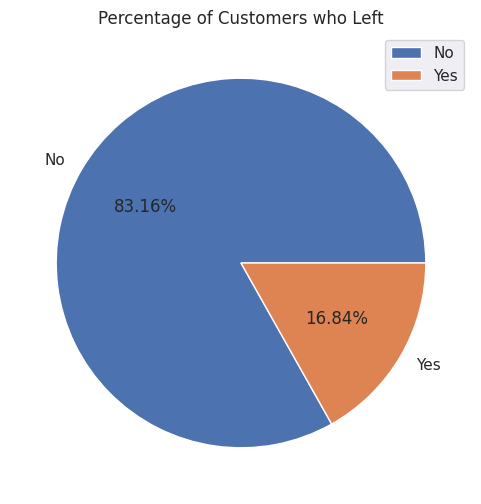

In [15]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = [15,6])

percent_count = ecom['Churn'].value_counts(normalize = True)
ax.pie(x = ecom['Churn'].value_counts(),labels = ["No", "Yes"], autopct = lambda percent_count: '{:.2f}%'.format(percent_count))
ax.set_title('Percentage of Customers who Left', fontsize = 12)
ax.legend()

plt.show()

**Customer Satisfaction**: The high retention rate suggests that most customers are satisfied with the product or service. This could be due to effective customer service, high product quality, or competitive pricing.

**Areas for Improvement**: The 16.84% attrition rate indicates that there are still some customers who are not fully satisfied. Identifying the reasons behind their departure can help in formulating strategies to reduce this percentage.

**Customer Churn by Gender**

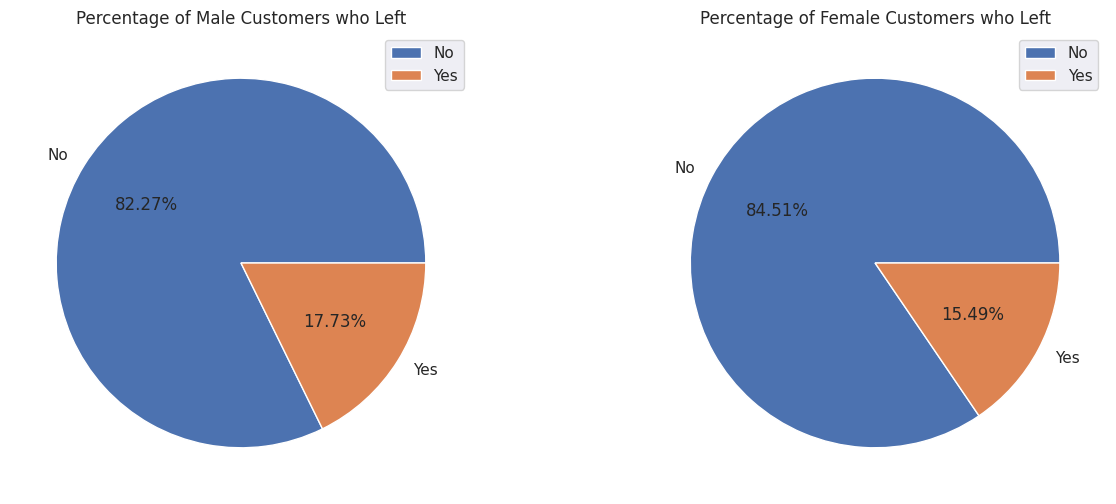

In [16]:
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = [15,6])

percent_count = ecom[ecom["Gender"] == "male"]['Churn'].value_counts(normalize = True)
ax1.pie(x = ecom[ecom["Gender"] == "male"]['Churn'].value_counts(),labels = ["No", "Yes"], autopct = lambda percent_count: '{:.2f}%'.format(percent_count))
ax1.set_title('Percentage of Male Customers who Left', fontsize = 12)
ax1.legend()

percent_count = ecom[ecom["Gender"] == "female"]['Churn'].value_counts(normalize = True)
ax2.pie(x = ecom[ecom["Gender"] == "female"]['Churn'].value_counts(),labels = ["No", "Yes"], autopct = lambda percent_count: '{:.2f}%'.format(percent_count))
ax2.set_title('Percentage of Female Customers who Left', fontsize = 12)
ax2.legend()

plt.show()

**Customer Satisfaction**: Both genders show high retention rates, indicating overall customer satisfaction. However, female customers appear to be slightly more satisfied or loyal.

**Targeted Strategies**: The higher attrition rate among male customers suggests a need for targeted strategies to improve their retention.



**Customer Churn by Tenure Range**

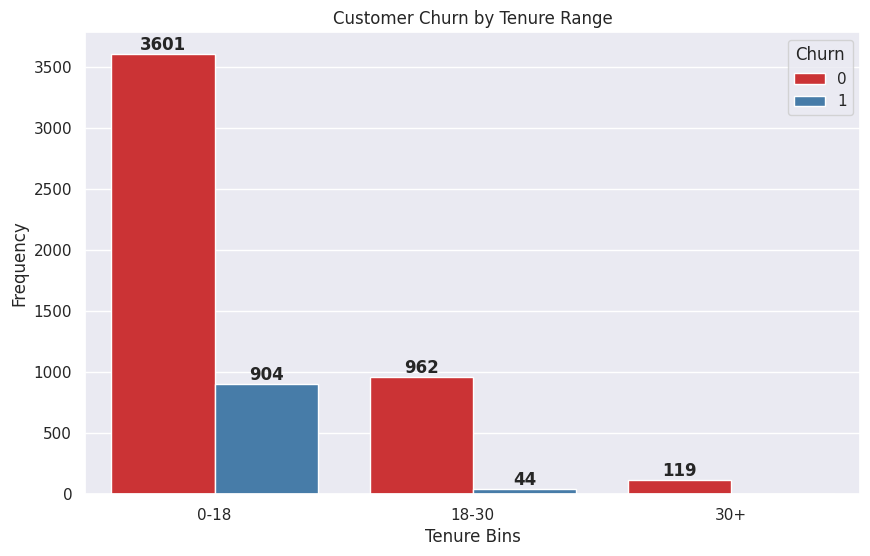

In [17]:
# Creating Tenure Groups
bins = [0, 18, 30, np.inf]
labels = ['0-18', '18-30', '30+']
ecom['TenureRange'] = pd.cut(ecom['Tenure'], bins = bins, labels = labels, right = False, include_lowest = True)

plt.figure(figsize=(10,6))
ax = sns.countplot(data = ecom, x = 'TenureRange', hue = 'Churn', palette = 'Set1')

for p in ax.patches:
    height = p.get_height()
    if height > 0:
        ax.annotate(f'{int(height)}', 
                    (p.get_x() + p.get_width() / 2., height), 
                    ha = 'center', va = 'baseline', 
                    xytext = (0, 3), weight = 'bold',
                    textcoords = 'offset points')

plt.title('Customer Churn by Tenure Range')
plt.xlabel('Tenure Bins')
plt.ylabel('Frequency')
plt.show()


**Early Engagement**: The high churn rate in the first 18 months highlights the need for improved engagement and support for new customers. Ensuring a positive onboarding experience and addressing any initial issues promptly can help reduce early churn.

**Loyalty Programs**: The lower churn rates in the 18-30 and 30+ month ranges suggest that customers who stay longer are more loyal. Implementing loyalty programs and incentives for long-term customers can further enhance retention.

**Targeted Interventions**: Identifying the specific reasons for early churn and addressing them through targeted interventions can help improve overall retention rates.



**Average Estimated Monthly Spending by Tenure**

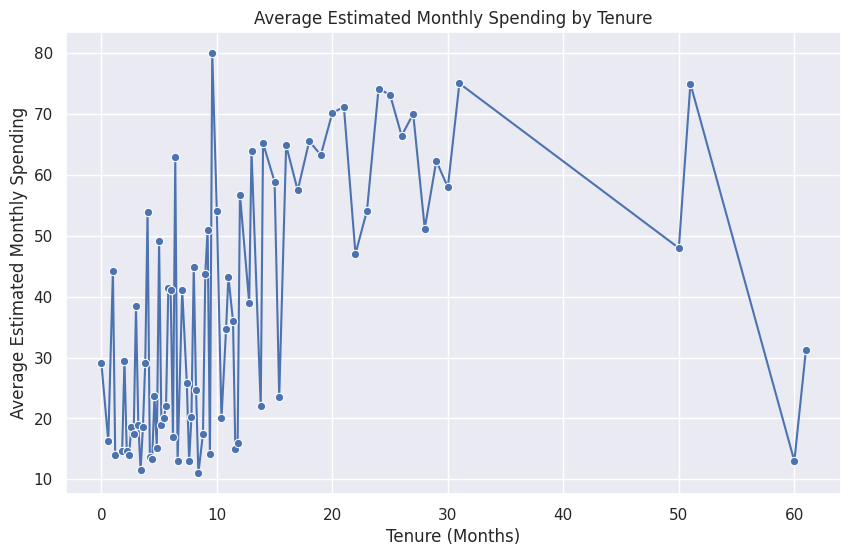

In [18]:
ecom['EstimatedMonthlySpending'] = ecom['OrderCount'] * ecom['OrderAmountHikeFromlastYear']
tenure_spending_avg = ecom.groupby('Tenure')['EstimatedMonthlySpending'].mean().reset_index()

plt.figure(figsize = (10,6))
sns.lineplot(data = tenure_spending_avg, x = 'Tenure', y = 'EstimatedMonthlySpending', marker = 'o')
plt.title('Average Estimated Monthly Spending by Tenure')
plt.xlabel('Tenure (Months)')
plt.ylabel('Average Estimated Monthly Spending')
plt.show()


**Early Engagement**: The high variability in spending among new customers highlights the importance of effective onboarding and engagement strategies to stabilize and increase spending.

**Mid-Tenure Challenges**: The drop in spending around 30 months suggests potential challenges in maintaining customer interest and satisfaction during this period. Identifying and addressing these challenges can help sustain spending levels.

**Long-Term Engagement**: The fluctuations in long-term spending indicate that even loyal customers may have periods of disengagement. Regularly refreshing engagement strategies can help maintain consistent spending.

**Churn by Satisfaction Score**

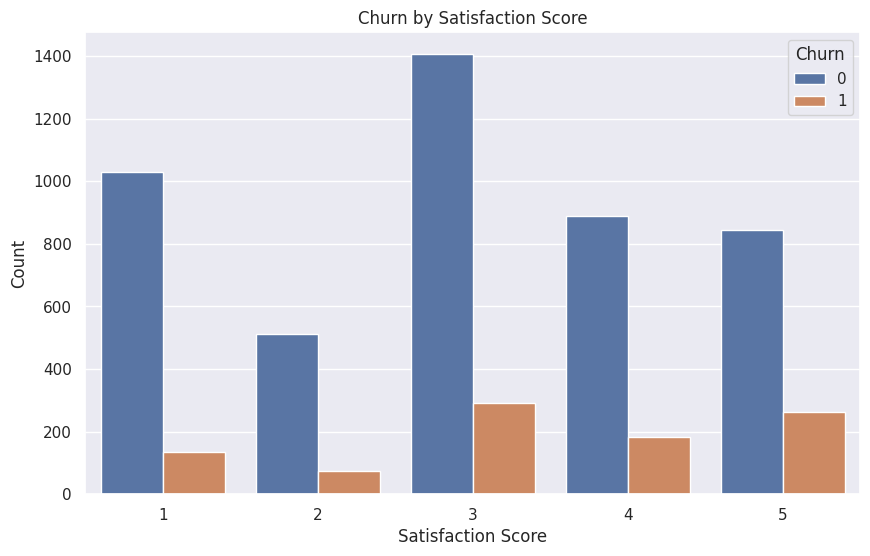

In [19]:
plt.figure(figsize = (10,6))
sns.countplot(data = ecom, x = 'SatisfactionScore', hue = 'Churn')
plt.title('Churn by Satisfaction Score')
plt.xlabel('Satisfaction Score')
plt.ylabel('Count')
plt.legend(title = 'Churn')
plt.show()

**Retention Despite Low Satisfaction**: The high retention rates among customers with low satisfaction scores could indicate that these customers might be staying due to lack of alternatives or other factors not directly related to satisfaction.

**Importance of Satisfaction**: The trend of decreasing churn with higher satisfaction scores underscores the importance of maintaining high customer satisfaction to reduce churn rates.



**Order Amount Hike by City Tier and Satisfaction Score**

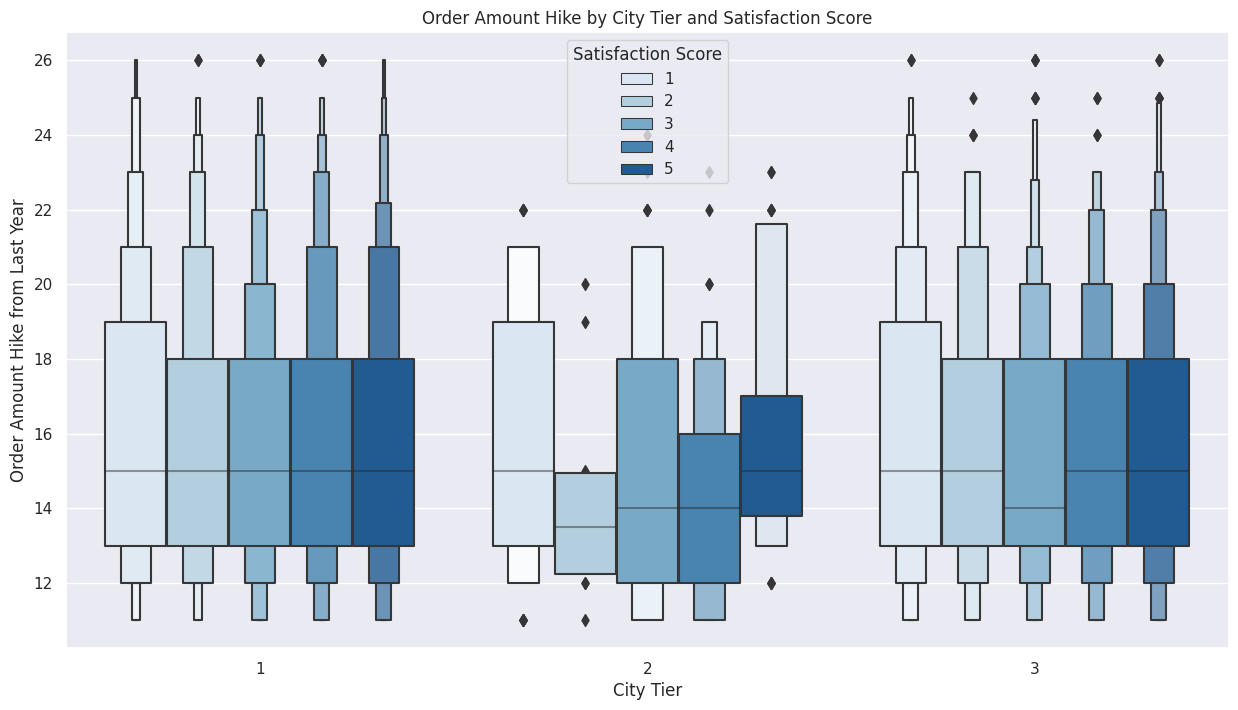

In [20]:
plt.figure(figsize=(15,8))
sns.boxenplot(data=ecom, x='CityTier', y='OrderAmountHikeFromlastYear', hue='SatisfactionScore', palette='Blues')
plt.title('Order Amount Hike by City Tier and Satisfaction Score')
plt.xlabel('City Tier')
plt.ylabel('Order Amount Hike from Last Year')
plt.legend(title='Satisfaction Score', loc = "upper center")
plt.show()

**Customer Behavior by City Tier**: Customers in higher city tiers (Tier 1) exhibit more variability in their spending behavior, possibly due to diverse economic conditions and spending power.

**Satisfaction and Spending Stability**: Higher satisfaction scores are linked to more stable spending patterns, indicating that satisfied customers are less likely to react drastically to order amount hikes.

**Pairplot of Continuous Variables by Churn Status**

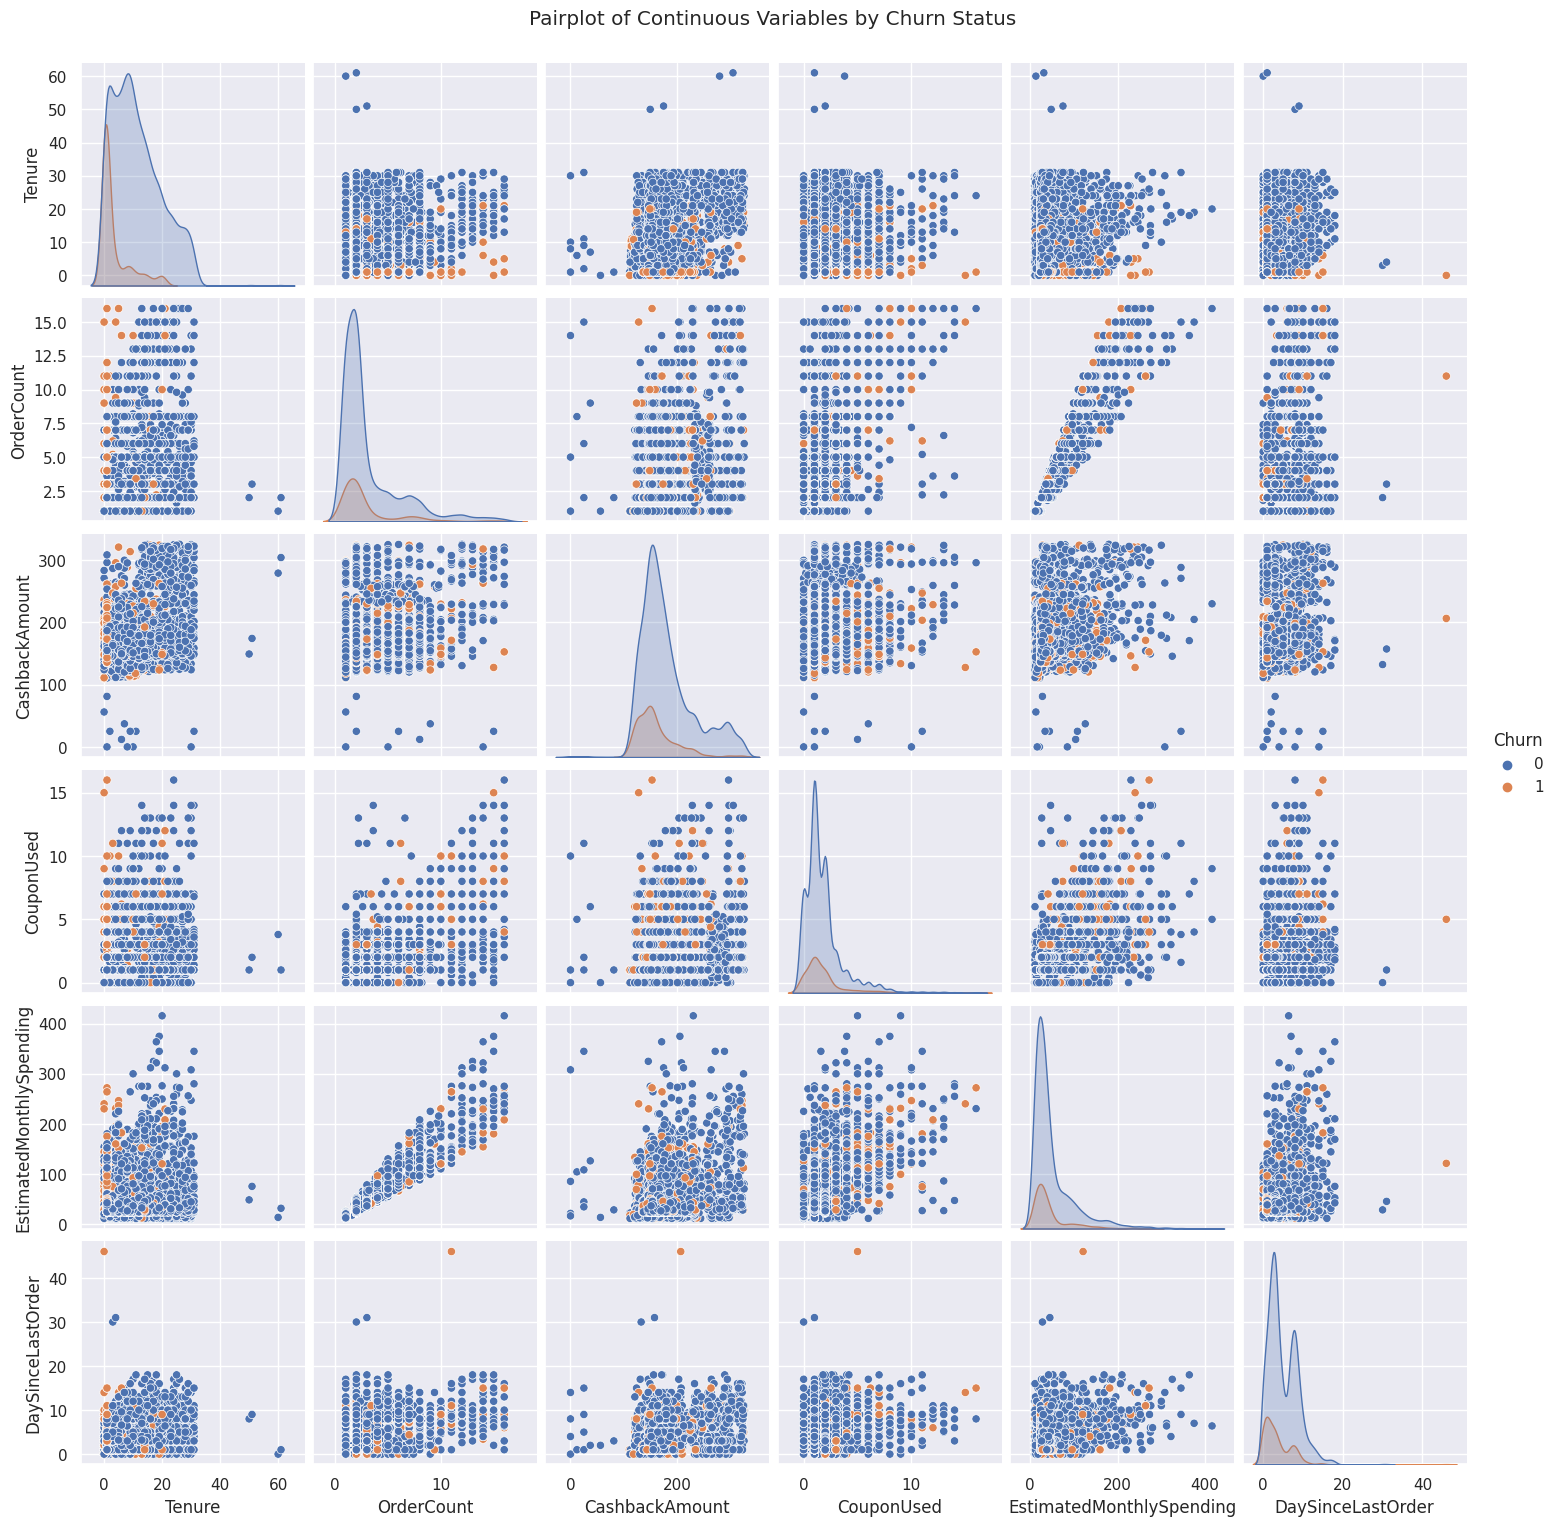

In [21]:
sns.pairplot(ecom, vars=['Tenure', 'OrderCount', 'CashbackAmount', 'CouponUsed','EstimatedMonthlySpending', 'DaySinceLastOrder'], hue = 'Churn')
plt.suptitle('Pairplot of Continuous Variables by Churn Status', y = 1.02)
plt.show()

**Targeted Retention Strategies**: Focus on customers with shorter tenures and higher monthly charges for retention efforts. Personalized offers or discounts could help reduce churn in these segments.

**Demographic-Specific Interventions**: Develop targeted strategies for senior citizens and customers without partners or dependents to address their specific needs and reduce churn.

**Service Optimization**: Evaluate the impact of phone service and multiple lines on customer satisfaction and churn. Consider offering bundled services or incentives to customers with multiple lines to enhance retention.

## Fitting models to the Data

In [22]:
x = ecom.drop(columns = ["CustomerID", "Churn", "EstimatedMonthlySpending", "TenureRange"])
X = pd.get_dummies(x, drop_first = True)
y = ecom["Churn"]

In [23]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 123)

**Logistic Regression**

In [24]:
log = LogisticRegression(random_state = 123)
log.fit(x_train, y_train)

LogisticRegression(random_state=123)

In [25]:
y_pred = log.predict(x_test)

In [26]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.96      0.94       938
           1       0.74      0.53      0.62       188

    accuracy                           0.89      1126
   macro avg       0.82      0.75      0.78      1126
weighted avg       0.88      0.89      0.88      1126



<Axes: >

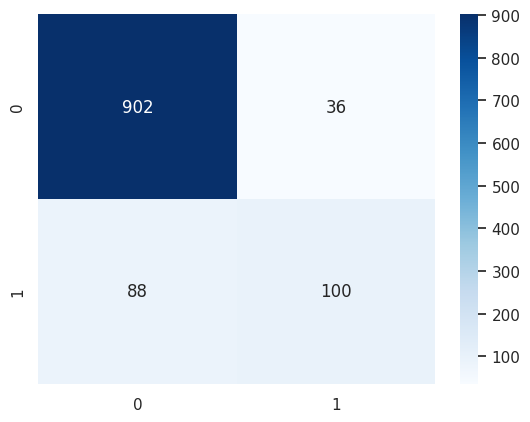

In [27]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot = True, fmt = ".5g", cmap = "Blues")

**Decision Tree**

In [28]:
dt = DecisionTreeClassifier(random_state = 123)
dt.fit(x_train, y_train)

DecisionTreeClassifier(random_state=123)

In [29]:
y_pred = dt.predict(x_test)

In [30]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.96      0.97       938
           1       0.82      0.87      0.84       188

    accuracy                           0.95      1126
   macro avg       0.90      0.91      0.90      1126
weighted avg       0.95      0.95      0.95      1126



<Axes: >

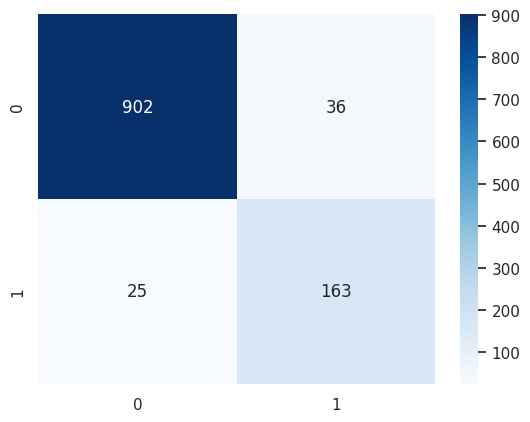

In [31]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot = True, fmt = ".5g", cmap = "Blues")

**Random Forest**

In [32]:
rf = RandomForestClassifier(random_state = 123)
rf.fit(x_train, y_train)

RandomForestClassifier(random_state=123)

In [33]:
y_pred = rf.predict(x_test)

In [34]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       938
           1       0.96      0.84      0.89       188

    accuracy                           0.97      1126
   macro avg       0.97      0.91      0.94      1126
weighted avg       0.97      0.97      0.97      1126



<Axes: >

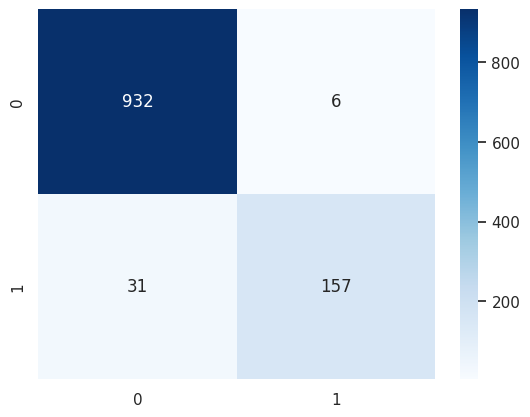

In [35]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot = True, fmt = ".5g", cmap = "Blues")

In [36]:
# Predicting the whole dataset using the model
Y_pred = rf.predict(X)

In [37]:
# Creating a dataset with customers corresponding to the predictions
new_df = pd.concat((ecom['CustomerID'], pd.Series(Y_pred)), axis = 1)
new_df.columns = ["CustomerID", "Churn"]
new_df.head()

,CustomerID,Churn
0,50001,1
1,50002,1
2,50003,1
3,50004,1
4,50005,1


In [38]:
new_df[new_df['Churn'] == 1]

,CustomerID,Churn
0,50001,1
1,50002,1
2,50003,1
3,50004,1
4,50005,1
...,...,...
5556,55557,1
5598,55599,1
5602,55603,1
5604,55605,1


- Based on the model 923 customers from the whole dataset with the given corresponding ID's are likely to Churn in the future.

## Marketing Strategy

- **During the analysis it was found that most customers are leaving at the first few months of the service tenure. These customers churned maybe because they found a better alternative to what the company was already offering. A better understanding of the competitora as well as providing attractive offers to new customers can be a way to improve retention.**

- **Actively seeking feedback from customers who leave early as well as concentrating on providing flexible plans to cities where the customer satisfaction scores are low can be also implemented to reduce churn.**

- **Implementing regular follow-up to customers who recently joined can improve their perspective of the company as well as motivate them to refer others.**